In [1]:
# import libraries
import numpy as np
from IPython.display import display
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate, GlobalPhaseGate
from qiskit.visualization import plot_histogram

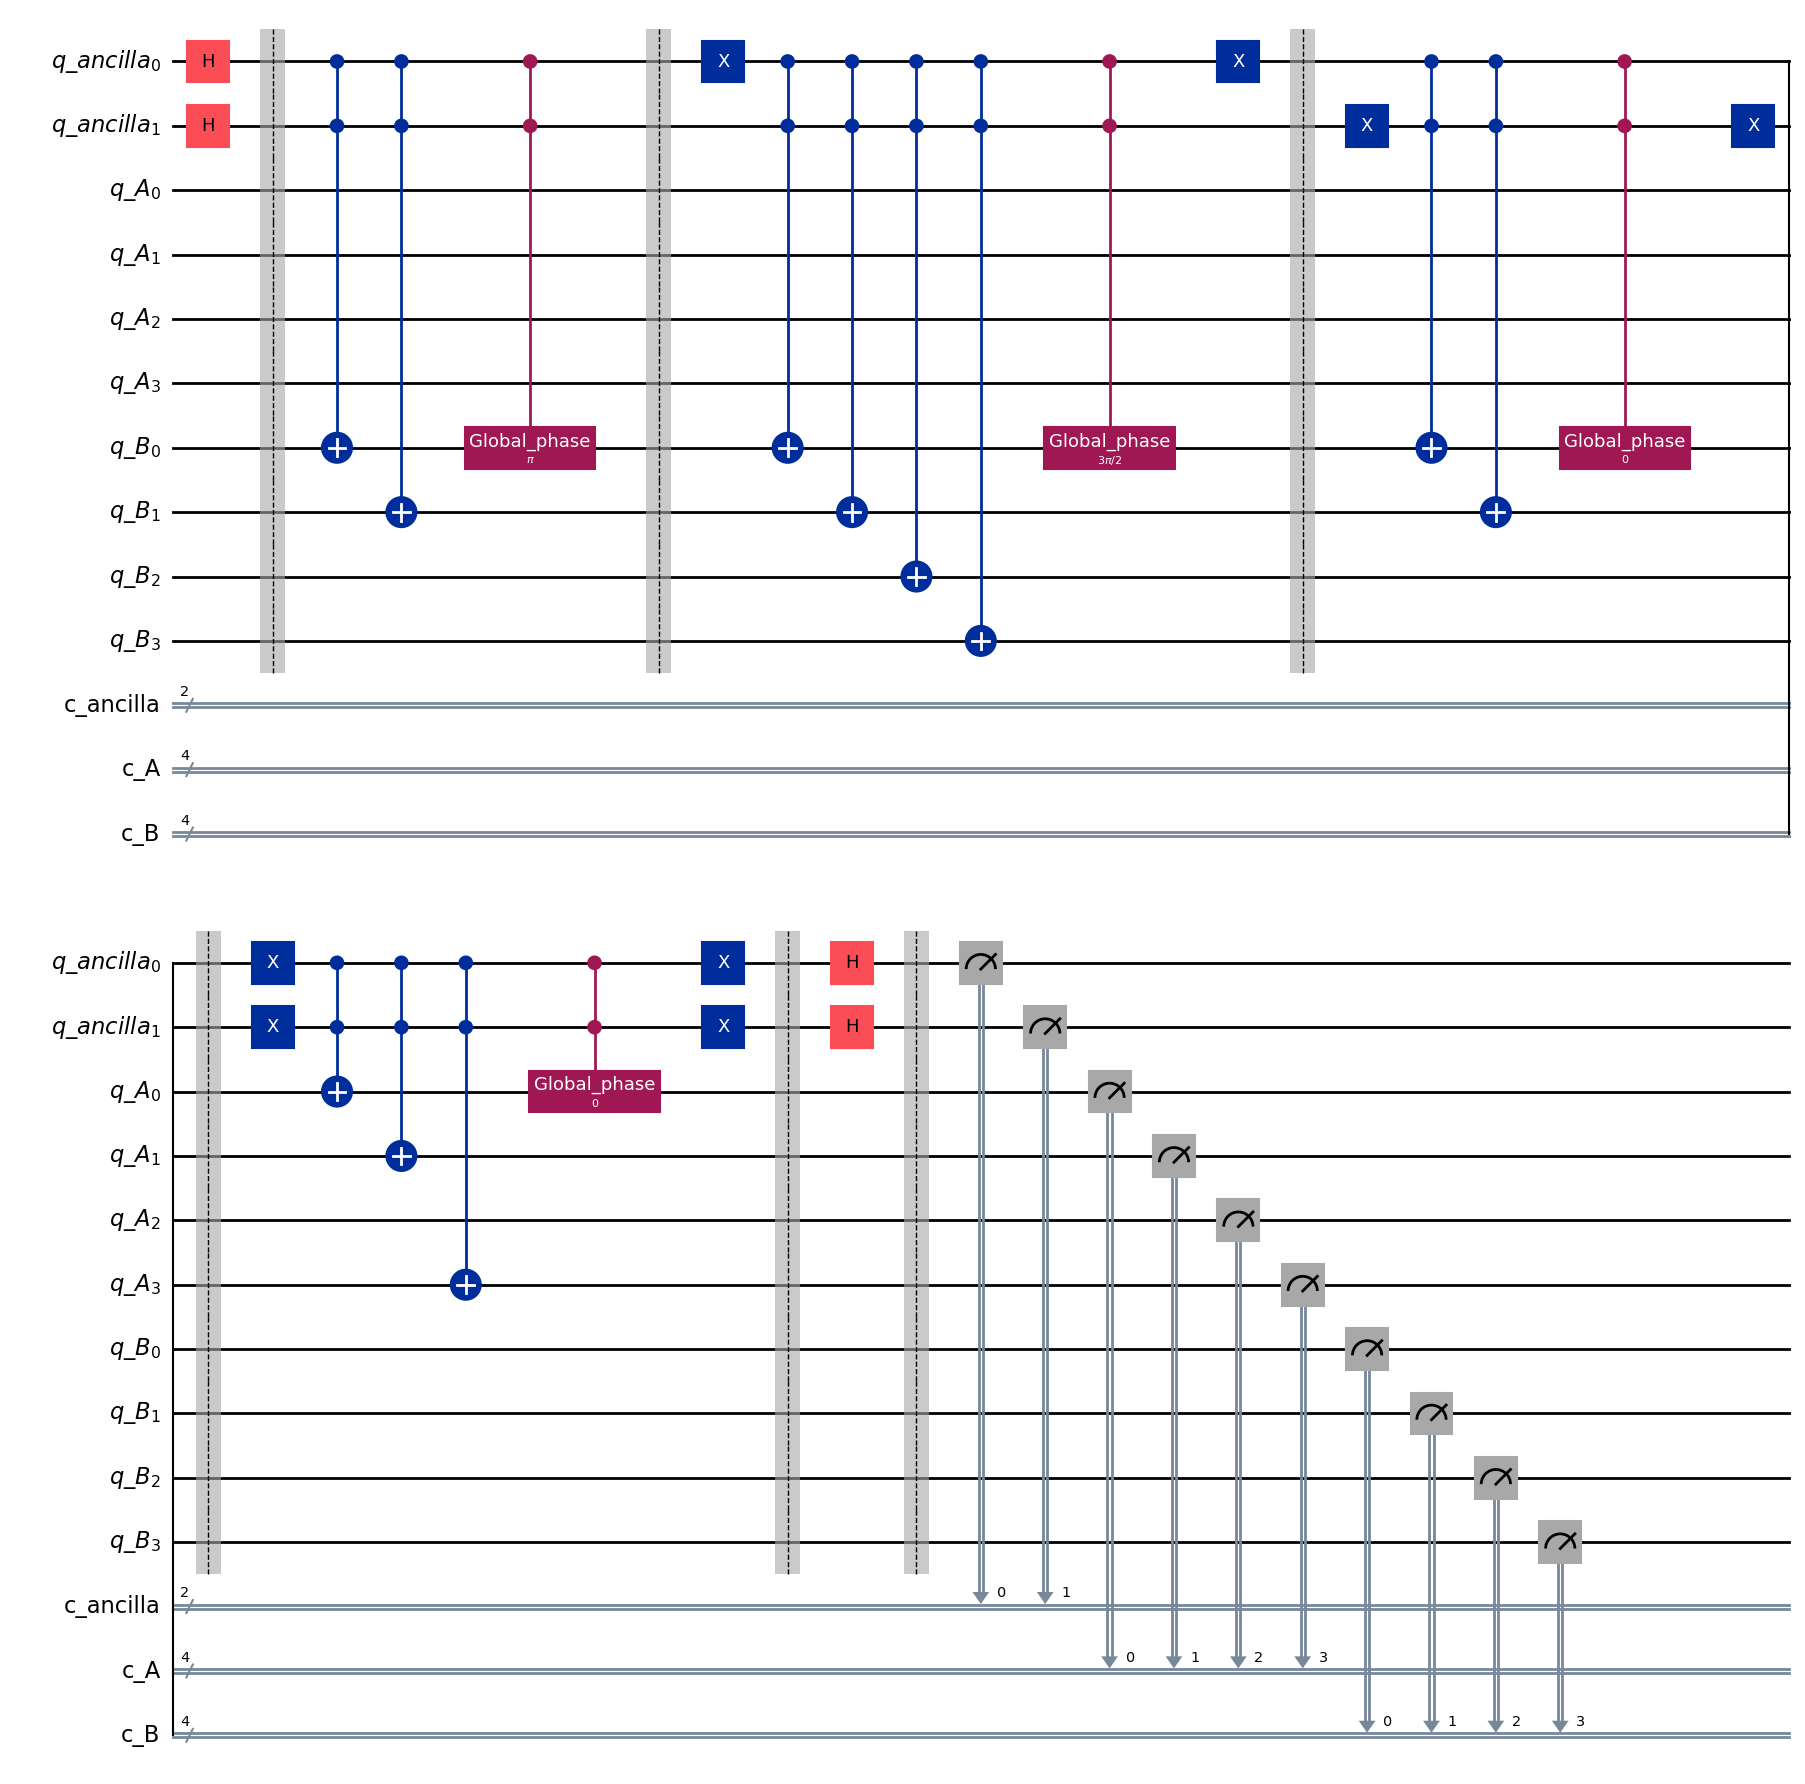

In [14]:
# number of the qubits for each register
n = 4

# positions and phases for both players in one round
positions = [3, 15, 3, 11]
phases = [np.pi, 3*np.pi/2, 0, 0]
fields = [1, 1, 1, 0]

states = len(positions)  # number of the states

def UGate(circuit, num, phase, qReg, controls):
    #gate = QuantumCircuit(qReg, name='$U_{'+str(num)+'}$')
    num_bin = bin(num)[2:].zfill(n)
    for i in range(n):
        if num_bin[-i-1] == '1':
            #gate.x(i)
            qubits = [controls[j] for j in range(controls.size)] + [qReg[i]]
            x = XGate().control(controls.size)
            circuit.append(x, qubits)
    GP = GlobalPhaseGate(phase)
    GP.num_qubits = 1
    qubits = [controls[j] for j in range(controls.size)] + [qReg[0]]
    circuit.append(GP.control(controls.size), qubits)
    return circuit

N_ancilas = int(np.ceil(np.log2(states)))

ancilla_qReg = QuantumRegister(N_ancilas, name='q_ancilla')
qReg_A = QuantumRegister(n, name='q_A')
qReg_B = QuantumRegister(n, name='q_B')
ancilla_cReg = ClassicalRegister(N_ancilas, name='c_ancilla')
cReg_A = ClassicalRegister(n, name='c_A')
cReg_B = ClassicalRegister(n, name='c_B')

circuit = QuantumCircuit(ancilla_qReg, qReg_A, qReg_B, ancilla_cReg, cReg_A, cReg_B)

for i in range(N_ancilas):
    circuit.h(ancilla_qReg[i])
circuit.barrier()
for i in range(2**N_ancilas):
    bin_num = bin(i)[2:].zfill(N_ancilas)
    #  Putting X gates
    for j in range(N_ancilas):
        if bin_num[j] == '1':
            circuit.x(ancilla_qReg[-j-1])

    if fields[i] == 0:
        circuit = UGate(circuit, positions[i], phases[i], qReg_A, ancilla_qReg)
    else:
        circuit = UGate(circuit, positions[i], phases[i], qReg_B, ancilla_qReg)

    #  Removing the X gates
    for j in range(N_ancilas):
        if bin_num[j] == '1':
            circuit.x(ancilla_qReg[-j-1])
    circuit.barrier()

for i in range(N_ancilas):
    circuit.h(ancilla_qReg[i])
circuit.barrier()
circuit.measure(ancilla_qReg, ancilla_cReg)
circuit.measure(qReg_A, cReg_A)
circuit.measure(qReg_B, cReg_B)

display(circuit.draw(output='mpl'))
circuit = transpile(circuit)

simulator = AerSimulator(shots=2**16)
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit).result()
counts = result.get_counts()

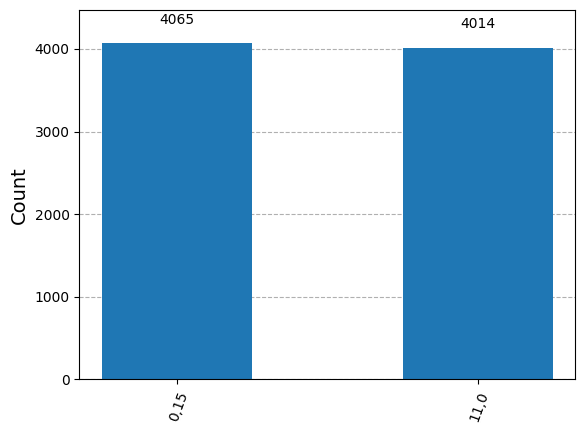

In [15]:
reduced_counts = dict()
for key in list(counts.keys()):
    if key[-2:] == '00':
        B = int(key[:4], 2)
        A = int(key[5:9], 2)
        reduced_counts['{},{}'.format(A, B)] = counts[key]
        
display(plot_histogram(reduced_counts))

In [16]:
def shot(coords, phases, fields, max_qubit_for_each):
    states = len(coords)  # number of the states
    n = max_qubit_for_each

    def UGate(circuit, num, phase, qReg, controls):
        #qReg = QuantumRegister(n)
        #gate = QuantumCircuit(qReg, name='$U_{'+str(num)+'}$')
        num_bin = bin(num)[2:].zfill(n)
        for i in range(n):
            if num_bin[-i-1] == '1':
                #gate.x(i)
                qubits = [controls[j] for j in range(controls.size)] + [qReg[i]]
                x = XGate().control(controls.size)
                circuit.append(x, qubits)
        GP = GlobalPhaseGate(phase)
        GP.num_qubits = 1
        qubits = [controls[j] for j in range(controls.size)] + [qReg[0]]
        circuit.append(GP.control(controls.size), qubits)
        return circuit

    N_ancilas = int(np.ceil(np.log2(states)))

    ancilla_qReg = QuantumRegister(N_ancilas, name='q_ancilla')
    qReg_A = QuantumRegister(n, name='q_A')
    qReg_B = QuantumRegister(n, name='q_B')
    ancilla_cReg = ClassicalRegister(N_ancilas, name='c_ancilla')
    cReg_A = ClassicalRegister(n, name='c_A')
    cReg_B = ClassicalRegister(n, name='c_B')

    circuit = QuantumCircuit(ancilla_qReg, qReg_A, qReg_B, ancilla_cReg, cReg_A, cReg_B)

    for i in range(N_ancilas):
        circuit.h(ancilla_qReg[i])
    circuit.barrier()
    for i in range(2**N_ancilas):
        bin_num = bin(i)[2:].zfill(N_ancilas)
        #  Putting X gates
        for j in range(N_ancilas):
            if bin_num[j] == '1':
                circuit.x(ancilla_qReg[-j-1])

        if fields[i] == 0:
            circuit = UGate(circuit, coords[i], phases[i], qReg_A, ancilla_qReg)
        else:
            circuit = UGate(circuit, coords[i], phases[i], qReg_B, ancilla_qReg)

        #  Removing the X gates
        for j in range(N_ancilas):
            if bin_num[j] == '1':
                circuit.x(ancilla_qReg[-j-1])
        circuit.barrier()

    for i in range(N_ancilas):
        circuit.h(ancilla_qReg[i])
    circuit.barrier()
    circuit.measure(ancilla_qReg, ancilla_cReg)
    circuit.measure(qReg_A, cReg_A)
    circuit.measure(qReg_B, cReg_B)

    simulator = AerSimulator(shots=1)
    compiled_circuit = transpile(circuit, simulator)
    ancila_values = '11'
    while ancila_values != '00':
        result = simulator.run(compiled_circuit).result()
        counts = result.get_counts()
        ancila_values = list(counts.keys())[0][-2:]

    key = list(counts.keys())[0]
    B = int(key[:4], 2)
    A = int(key[5:9], 2)
    return A, B


# positions = [5, 9, 5, 3]
# phases = [0, np.pi, 9*np.pi/10, 0]
# fields = [1, 1, 1, 0]

# positions = [3, 15, 2, 11]
# phases = [np.pi, 3*np.pi/2, 9*np.pi/10, 0]
# fields = [1, 1, 0, 0]
# max_qubit_for_each = 4

positions = [3, 15, 3, 11]
phases = [np.pi, 3*np.pi/2, 0, 0]
fields = [1, 1, 1, 0]
max_qubit_for_each = 4

shot(positions, phases, fields, max_qubit_for_each)

(11, 0)

In [17]:
row_size=4
col_size = 4
s1, s2 = shot(positions, phases, fields, max_qubit_for_each)
def idx_to_rc(idx):
    """Convert circuit index → (row, col).
       0  ➜  (-1,-1)   means “no hit”
       1  ➜  (0,0)     first tile
       .
    """
    if idx == 0:
        return 0, 0                 # sentinel = “nothing happened”
    idx -= 1                           # shift from 1-based to 0-based
    return idx // col_size, idx % col_size

#simple, correct conversion
h1r, h1c = idx_to_rc(s1)     # hit on responder
h2r, h2c = idx_to_rc(s2)
print(h1r,h1c,h2r,h2c)

0 0 3 2


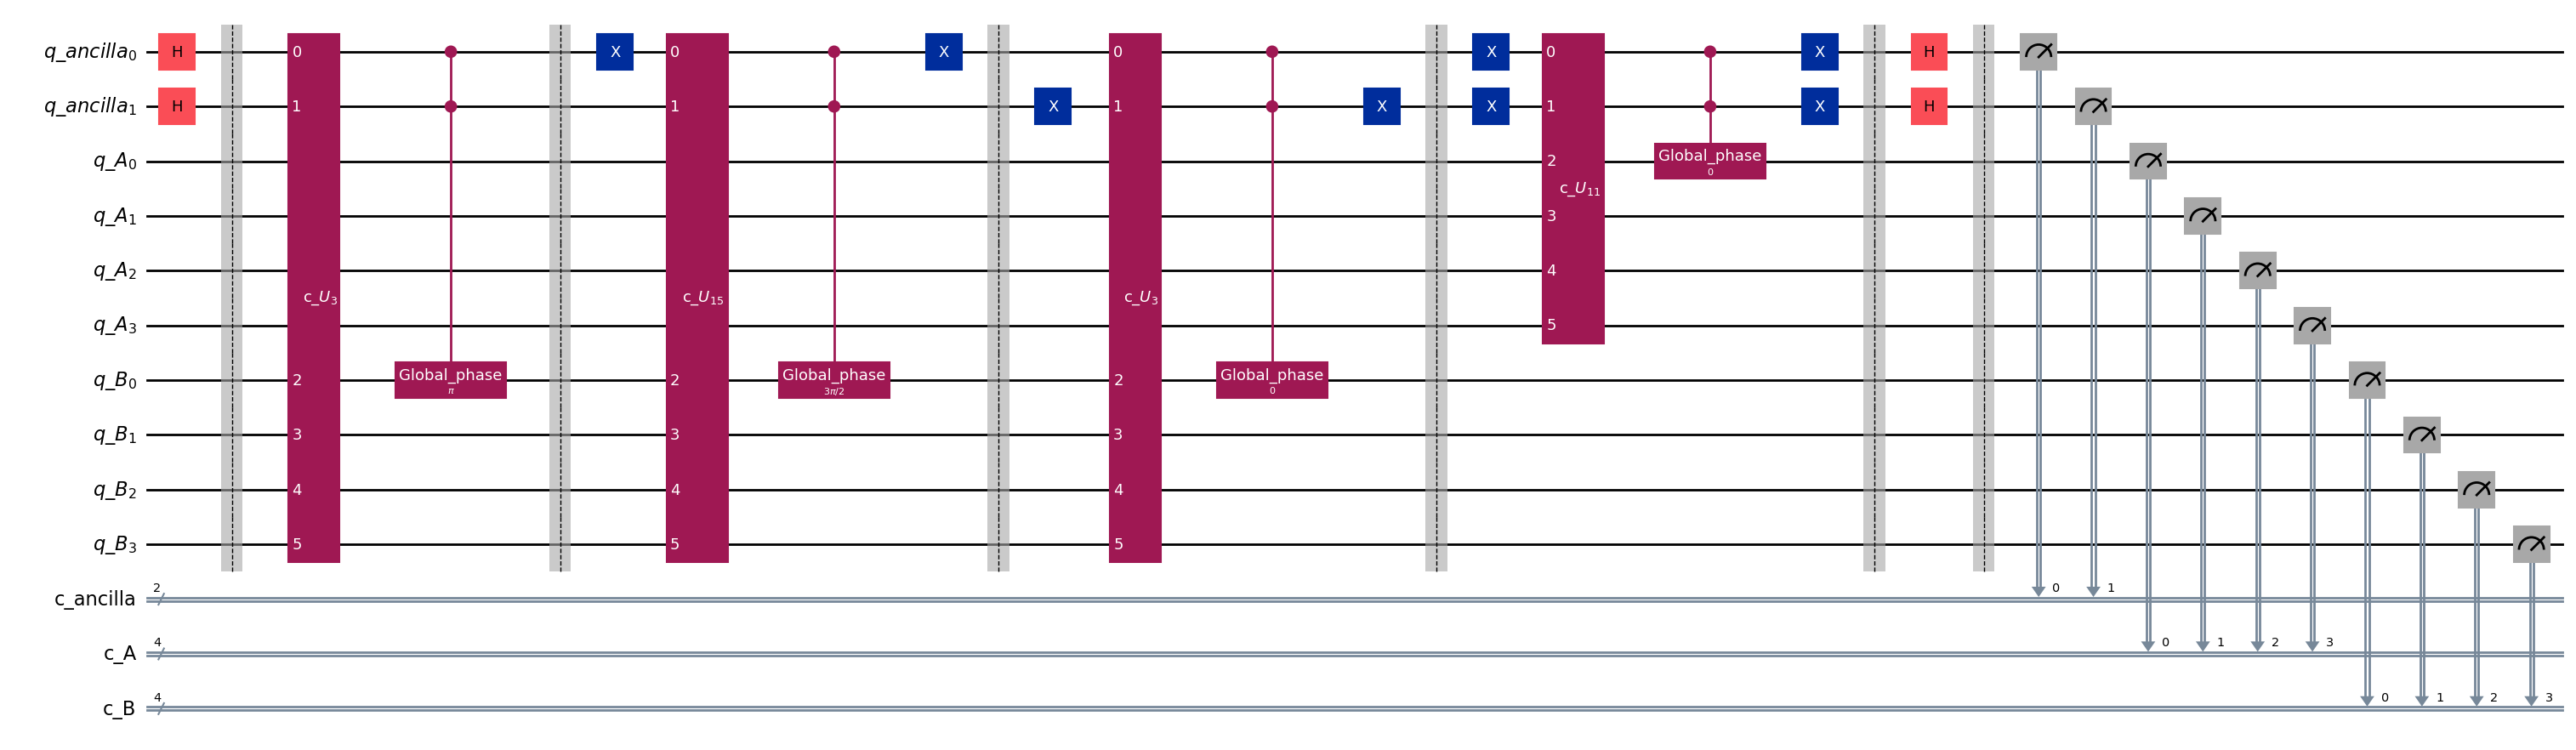

In [7]:
# number of the qubits for each register
n = 4

# positions and phases for both players in one round
positions = [3, 15, 3, 11]
phases = [np.pi, 3*np.pi/2, 0, 0]
fields = [1, 1, 1, 0]

states = len(positions)  # number of the states

def UGate(circuit, num, phase, qReg, controls):
    subqReg = QuantumRegister(qReg.size)
    gate = QuantumCircuit(subqReg, name='$U_{'+str(num)+'}$')
    num_bin = bin(num)[2:].zfill(n)
    for i in range(n):
        if num_bin[-i-1] == '1':
            gate.x(i)
    qubits = [controls[j] for j in range(controls.size)] + [qReg[j] for j in range(qReg.size)]
    circuit.append(gate.control(2), qubits)
    GP = GlobalPhaseGate(phase)
    GP.num_qubits = 1
    qubits = [controls[j] for j in range(controls.size)] + [qReg[0]]
    circuit.append(GP.control(controls.size), qubits)
    return circuit

N_ancilas = int(np.ceil(np.log2(states)))

ancilla_qReg = QuantumRegister(N_ancilas, name='q_ancilla')
qReg_A = QuantumRegister(n, name='q_A')
qReg_B = QuantumRegister(n, name='q_B')
ancilla_cReg = ClassicalRegister(N_ancilas, name='c_ancilla')
cReg_A = ClassicalRegister(n, name='c_A')
cReg_B = ClassicalRegister(n, name='c_B')

circuit = QuantumCircuit(ancilla_qReg, qReg_A, qReg_B, ancilla_cReg, cReg_A, cReg_B)

for i in range(N_ancilas):
    circuit.h(ancilla_qReg[i])
circuit.barrier()
for i in range(2**N_ancilas):
    bin_num = bin(i)[2:].zfill(N_ancilas)
    #  Putting X gates
    for j in range(N_ancilas):
        if bin_num[j] == '1':
            circuit.x(ancilla_qReg[-j-1])

    if fields[i] == 0:
        circuit = UGate(circuit, positions[i], phases[i], qReg_A, ancilla_qReg)
    else:
        circuit = UGate(circuit, positions[i], phases[i], qReg_B, ancilla_qReg)

    #  Removing the X gates
    for j in range(N_ancilas):
        if bin_num[j] == '1':
            circuit.x(ancilla_qReg[-j-1])
    circuit.barrier()

for i in range(N_ancilas):
    circuit.h(ancilla_qReg[i])
circuit.barrier()
circuit.measure(ancilla_qReg, ancilla_cReg)
circuit.measure(qReg_A, cReg_A)
circuit.measure(qReg_B, cReg_B)

display(circuit.draw(output='mpl', fold=1))
# circuit = transpile(circuit)
# 
# simulator = AerSimulator(shots=2**16)
# compiled_circuit = transpile(circuit, simulator)
# result = simulator.run(compiled_circuit).result()
# counts = result.get_counts()